# Check supported GPU for NVIDIA

In [294]:
import torch

cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()

print(f"CUDA Available: {cuda_available}")
print(f"Number of CUDA Devices: {cuda_device_count}")

if cuda_available:
    for i in range(cuda_device_count):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

CUDA Available: False
Number of CUDA Devices: 0


# Check supported GPU for AMD

In [295]:
import torch

if hasattr(torch.backends, 'rocm') and torch.backends.rocm.is_available():
    rocm_device_count = torch.cuda.device_count()
    print(f"Number of ROCm Devices: {rocm_device_count}")
else:
    print("ROCm is not available or not supported in this PyTorch installation.")

ROCm is not available or not supported in this PyTorch installation.


# I. Libraries

In [296]:
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [297]:
device = torch.device('rocm:0' if hasattr(torch.backends, 'rocm') and torch.backends.rocm.is_available() 
                      else 'cuda:0' if torch.cuda.is_available() 
                      else 'cpu')

# II. Prepare Dataset

## *2.1. Set fix random*

In [298]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
set_seed(seed)

## *2.2. Load dataset*

In [299]:
root = './data'

train_data = datasets.MNIST(
    root=root,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=root,
    train=False,
    download=True
    )

print(f'Train shape: {train_data.data.shape}')
print(f'Train classes: {train_data.classes}')
print(f'Train labels: {train_data.targets}')

Train shape: torch.Size([60000, 28, 28])
Train classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Train labels: tensor([5, 0, 4,  ..., 5, 6, 8])


In [300]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='bone')
        ax.axis('off')

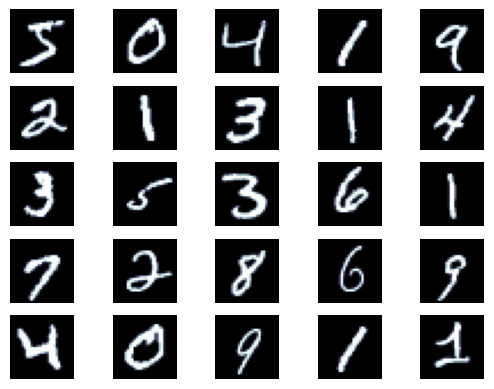

In [301]:
n_images = 25

images = [image for image, label in [train_data[i] for i in range(n_images)]]

plot_images(images)

## *2.3. Split dataset*

In [302]:
train_ratio = 0.9

train_size = int(len(train_data) * train_ratio)
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, 
                                    [train_size, val_size])

print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

Train size: 54000
Validation size: 6000
Test size: 10000


# III. Preprocessing

## *3.1. Data Normalization*

**Preprocessing with `transforms`**

- Normalization (mean, sdt)
- Convert to tensor

In [303]:
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255
mean, std

(tensor(0.1307), tensor(0.3081))

In [304]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [305]:
train_data.dataset.transform = train_transforms
val_data.dataset.transform = train_transforms

## *3.2. Dataloader*

In [306]:
batch_size = 256

train_dataloader = DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=batch_size
)

valid_dataloader = DataLoader(
    dataset=val_data,
    batch_size=batch_size
)

# IV. Training model

## *4.1. Model*

In [307]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()    
        self.model = nn.Sequential(                     # (1, 28, 28)
            nn.Conv2d(in_channels=1,
                      out_channels=6,
                      kernel_size=5, 
                      padding='same'),                  # (6, 28, 28)
            nn.AvgPool2d(kernel_size=2, stride=2),      # (6, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=6, 
                      out_channels=16,
                      kernel_size=5),                   # (16, 10, 10)
            nn.AvgPool2d(kernel_size=2, stride=2),      # (16, 5, 5)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, num_classes)
        )


    def forward(self, x):
        return self.model(x)

In [308]:
lenet_model = LeNetClassifier(
    len(train_data.dataset.classes)
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

summary(lenet_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
              ReLU-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
         AvgPool2d-5             [-1, 16, 5, 5]               0
              ReLU-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.24
Estimated Tot

## *4.2. Trainer*

In [309]:
def train_function(model, optimizer, criterion, train_dataloader, 
                   valid_dataloader, device, 
                   epoch=1, log_interval=50, save_path='./model'):
    num_batches = len(train_dataloader)
    train_accs, train_losses = [], []
    val_accs, val_losses = [], []
    best_loss_val = 100
        
    for epoch in range(epoch):
        epoch_start_time = time.time()
        total_train_loss, total_train_acc, total_train_count = 0, 0, 0
        total_val_loss, total_val_acc, total_val_count = 0, 0, 0
        
        # Training model in 1 epoch
        model.train()
        for batch, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_train_acc += (predictions.argmax(1) == labels).sum().item()
            total_train_count += labels.size(0)
            
            if (batch + 1) % log_interval == 0 or (batch + 1) == num_batches:
                print(
                    "| epoch {:3d} | {:5d}/{:5d} batches "
                    "| accuracy {:8.3f}".format(
                        epoch, batch + 1, num_batches, 
                        total_train_acc / total_train_count
                    )
                )
                
        train_accs.append(total_train_acc / total_train_count)
        train_losses.append(total_train_loss / num_batches)    
                    
                
        # Evaluate model in 1 epoch        
        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                predictions = model(inputs)
                loss = criterion(predictions, labels)

                total_val_loss += loss.item()
                total_val_acc += (predictions.argmax(1) == labels).sum().item()
                total_val_count += labels.size(0)

        val_accs.append(total_val_acc / total_val_count)
        val_losses.append(total_val_loss / num_batches)        
        
        print("-" * 55)        
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s\n"
            "| Train Accuracy {:8.3f} | Train Loss {:8.3f}\n"
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
                epoch, time.time() - epoch_start_time, 
                total_train_acc / total_train_count, total_train_loss / num_batches,
                total_val_acc / total_val_count, total_val_loss / num_batches
                )
        )
        print("-" * 55)
        
        # Save best model
        if total_val_loss < best_loss_val or epoch == 0:
                best_loss_val = total_val_loss
                os.makedirs(save_path, exist_ok=True)
                torch.save(model.state_dict(), save_path + '/grayscale_lenet_model.pt')
                
        # Load best model
        model.load_state_dict(torch.load(save_path + '/grayscale_lenet_model.pt', weights_only=True))
        model.eval()
                            
    return train_accs, train_losses, val_accs, val_losses

In [310]:
def plot_result(num_epochs, train_accs, val_accs, train_losses, val_losses):
    epochs = list(range(num_epochs))
    _, axs = plt.subplots(nrows=1, ncols=2 , figsize=(12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, val_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, val_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

## *4.4. Training*

| epoch   0 |    50/  211 batches | accuracy    0.685
| epoch   0 |   100/  211 batches | accuracy    0.782
| epoch   0 |   150/  211 batches | accuracy    0.825
| epoch   0 |   200/  211 batches | accuracy    0.853
| epoch   0 |   211/  211 batches | accuracy    0.857
-------------------------------------------------------
| End of epoch   0 | Time: 26.50s
| Train Accuracy    0.857 | Train Loss    0.499
| Valid Accuracy    0.944 | Valid Loss    0.022
-------------------------------------------------------
| epoch   1 |    50/  211 batches | accuracy    0.953
| epoch   1 |   100/  211 batches | accuracy    0.956
| epoch   1 |   150/  211 batches | accuracy    0.958
| epoch   1 |   200/  211 batches | accuracy    0.960
| epoch   1 |   211/  211 batches | accuracy    0.961
-------------------------------------------------------
| End of epoch   1 | Time: 30.34s
| Train Accuracy    0.961 | Train Loss    0.132
| Valid Accuracy    0.968 | Valid Loss    0.013
--------------------------------

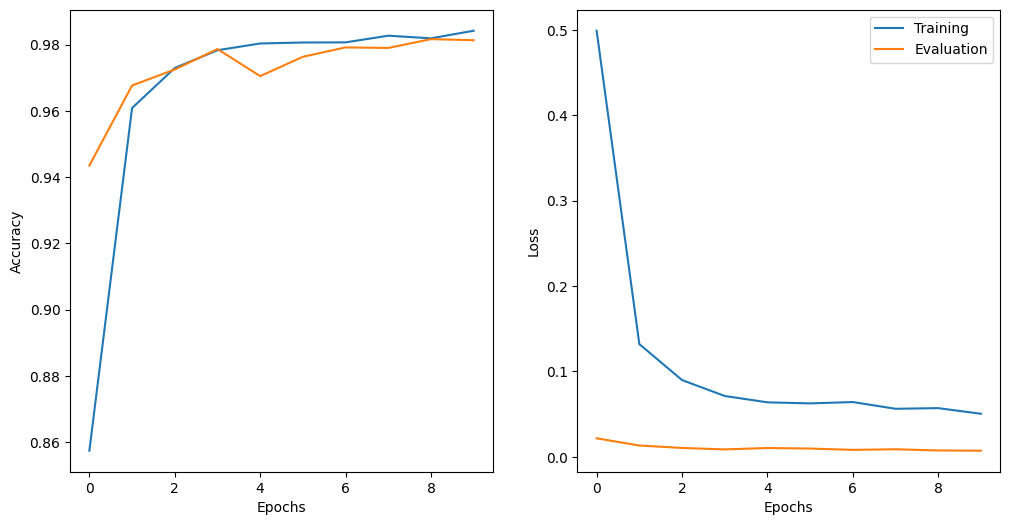

In [311]:
device = torch.device('rocm:0' if hasattr(torch.backends, 'rocm') and torch.backends.rocm.is_available() 
                      else 'cuda:0' if torch.cuda.is_available() 
                      else 'cpu')

lenet_model = LeNetClassifier(
    len(train_data.dataset.classes)
    ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_path = './model'

train_accs, train_losses, val_accs, val_losses = train_function(model=lenet_model,
                                                              optimizer=optimizer, 
                                                              criterion=criterion, 
                                                              train_dataloader=train_dataloader,
                                                              valid_dataloader=valid_dataloader, 
                                                              device=device,
                                                              epoch=num_epochs,
                                                              save_path=save_path)

plot_result(num_epochs=num_epochs,
            train_accs=train_accs, 
            val_accs=val_accs, 
            train_losses=train_losses, 
            val_losses=val_losses)


# V. Testing Trained Model

## *5.1. Preprocessing Test Dataset*

In [312]:
test_data.transform = train_transforms

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size
)

## *5.2. Tester*

In [313]:
def test_funct(model, criterion, test_dataloader, device):
    test_loss, test_acc, test_count = 0, 0, 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            test_loss += loss.item()
            test_acc += (predictions.argmax(1) == labels).sum().item()
            test_count += labels.size(0)

    test_loss /= len(train_dataloader)
    test_acc /= test_count
    
    return test_loss, test_acc

In [314]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

## *5.3. Testing*

In [315]:
test_loss, test_acc = test_funct(model=lenet_model, 
                                 criterion=criterion, 
                                 test_dataloader=test_dataloader,
                                 device=device)
test_loss, test_acc

(0.008745689311404646, 0.9836)

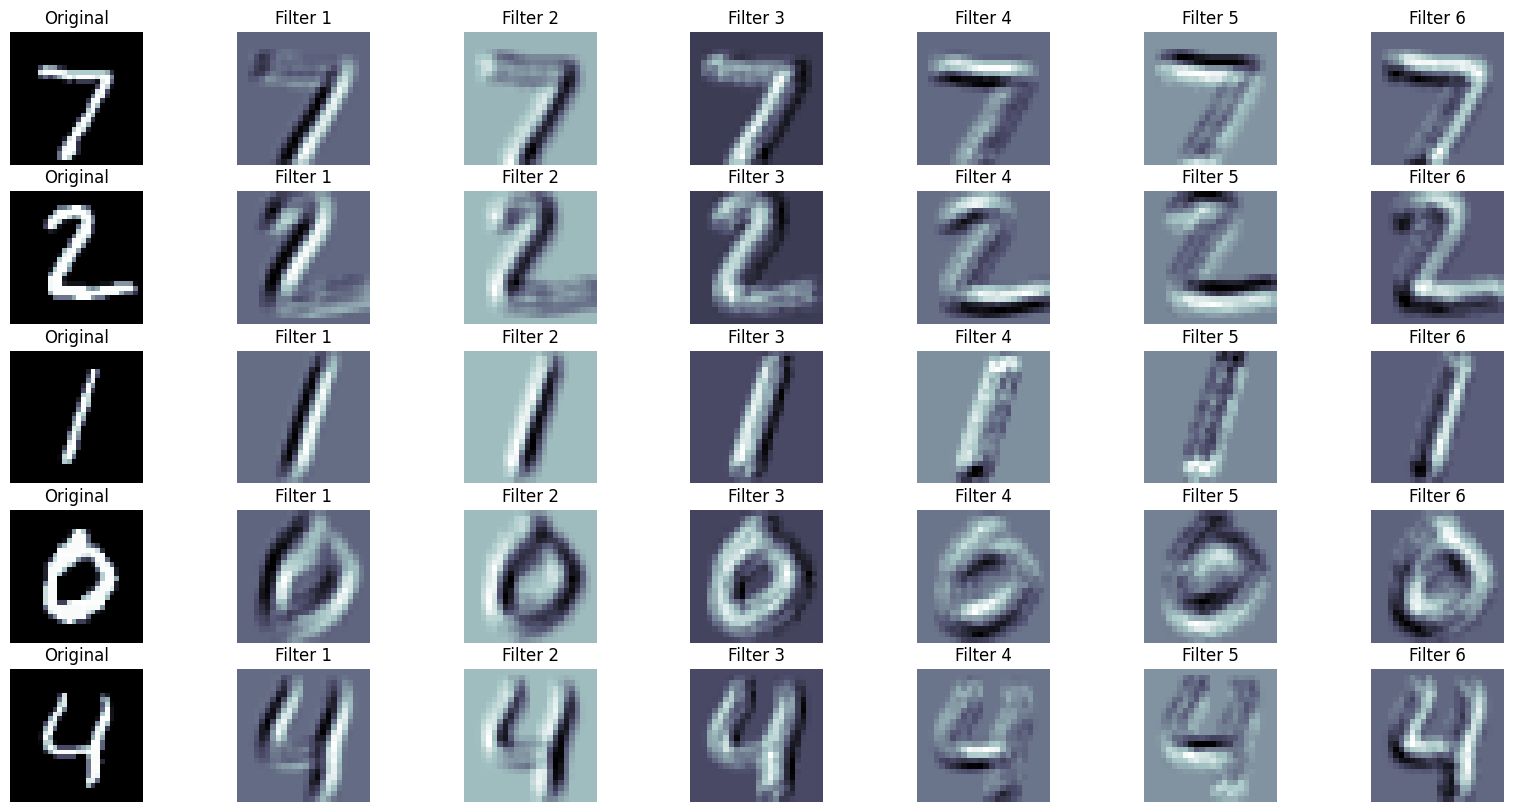

In [316]:
n_images = 5

images = [image for image, _ in [test_data[i] for i in range(n_images)]]
filters = lenet_model.model[0].weight.data

plot_filtered_images(images, filters)

# VI. Inference

In [317]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()    
        self.model = nn.Sequential(                     # (1, 28, 28)
            nn.Conv2d(in_channels=1,
                      out_channels=6,
                      kernel_size=5, 
                      padding='same'),                  # (6, 28, 28)
            nn.AvgPool2d(kernel_size=2, stride=2),      # (6, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=6, 
                      out_channels=16,
                      kernel_size=5),                   # (16, 10, 10)
            nn.AvgPool2d(kernel_size=2, stride=2),      # (16, 5, 5)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, num_classes)
        )


    def forward(self, x):
        return self.model(x)


def load_model(model_path, num_classes=10):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model


def inference(img_path, model):
    image = Image.open(img_path)
    w, h = image.size
    
    if w != h:
        crop = transforms.CenterCrop(min(w, h))
        image = crop(image)
        
    img_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])
    ])
    img_new = img_transform(image)
    img_new = img_new.expand(1, 1, 28, 28)
    
    model.eval()
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    
    return p_max.item(), yhat.item()

In [318]:
model = load_model('./model/grayscale_lenet_model.pt')
preds = inference('./demo_8.png', model)
preds

(0.9997437596321106, 8)